In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import utils
from Sampling import Sampling
from VAE import VAE
from CAN import CAN

In [2]:
vae_epoch = 10000
vae_batch_size = 128
latent_dim = 10
beta_eeg = 5.0
test_split = 0.2
can_epoch = 10000
can_batch_size = 16
train = False

In [4]:
# Read data sets
erp, pupil = utils.read_data_sets()
erp_train, erp_test, pupil_train, pupil_test = train_test_split(
    erp, pupil, test_size=0.2, shuffle=False
)

In [5]:
# Load all encoders/decoders
vae = VAE(beta=beta_eeg, latent_dim=latent_dim)
vae.encoder = keras.models.load_model("vae_encoder")
vae.decoder = keras.models.load_model("vae_decoder")

can = CAN(vae=vae, vae_data=erp_train, latent_dim=latent_dim)
can.encoder = keras.models.load_model("can_encoder")
can.decoder = keras.models.load_model("can_decoder")

In [6]:
erp_encode = vae.encoder.predict(erp)
pupil_encode = can.encoder.predict(pupil)

ee_rec = vae.decoder.predict(erp_encode)
ep_rec = can.decoder.predict(erp_encode)
pp_rec = can.decoder.predict(pupil_encode)
pe_rec = vae.decoder.predict(pupil_encode)

In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [8, 8]

def plot_erp_reconstruction(orig, rec, save=False, filename=''):
    orig, rec = np.squeeze(orig), np.squeeze(rec)
    orig = np.mean(orig, axis=0)
    rec = np.mean(rec, axis=0)
    #mm_rec = minmax_scale(rec, feature_range=(orig.min(),orig.max()))

    plt.subplot(2, 1, 1)
    plt.plot(orig[:len(orig)//2], label='Original')
    plt.plot(rec[:len(rec)//2], label='Reconstruction')
    plt.legend(loc="upper left")
    plt.ylabel('Targets')

    plt.subplot(2, 1, 2)
    plt.plot(orig[len(orig)//2:], label='Original')
    plt.plot(rec[len(rec)//2:], label='Reconstruction')    
    plt.xlabel('Data Points (#)')
    plt.ylabel('Distractors')
    plt.legend(loc="upper left")
    fig = plt.gcf()
    plt.show()
    
    err_t = np.sqrt(mean_squared_error(orig[:len(orig)//2], rec[:len(rec)//2]))
    err_d = np.sqrt(mean_squared_error(orig[len(orig)//2:], rec[len(rec)//2:]))
    t_err = str(err_t)    
    d_err = str(err_d)
    idx_t = t_err.find('.')
    idx_d = d_err.find('.')
    t_err = t_err[idx_t+1:idx_t+5]
    d_err = d_err[idx_d+1:idx_d+5]
    
    if save:
        fig.savefig(filename + '_t' + str(t_err) + '_d' + str(d_err) + '.png')
        
    print('RMSE Targets: ' + str(err_t))
    print('RMSE Distractors: ' + str(err_d))

In [132]:
def plot_pupil_reconstruction(orig, rec, save=False, filename=''):
    orig, rec = np.squeeze(orig), np.squeeze(rec)
    lo = orig[0]
    lr = rec[0]
    ro = orig[1]
    rr = rec[1]
    
    half = len(lo)//2
    
    plt.subplot(2, 1, 1)
    plt.plot(lo[:half], label='Left Original')
    plt.plot(lr[:half], label='Left Reconstruction')
    plt.plot(ro[:half], label='Right Original')
    plt.plot(rr[:half], label='Right Reconstruction')
    plt.legend(loc="upper left")
    plt.ylabel('Targets')

    plt.subplot(2, 1, 2)
    plt.plot(lo[half:], label='Left Original')
    plt.plot(lr[half:], label='Left Reconstruction')
    plt.plot(ro[half:], label='Right Original')
    plt.plot(rr[half:], label='Right Reconstruction')  
    plt.xlabel('Data Points (#)')
    plt.ylabel('Distractors')
    plt.legend(loc="upper left")
    fig = plt.gcf()
    plt.show()
    
    err_t_l = np.sqrt(mean_squared_error(lo[:half], lr[:half]))
    err_t_r = np.sqrt(mean_squared_error(ro[:half], rr[:half]))
    err_d_l = np.sqrt(mean_squared_error(lo[half:], lr[half:]))
    err_d_r = np.sqrt(mean_squared_error(ro[half:], rr[half:]))
    t_err_l = str(err_t_l)    
    d_err_l = str(err_d_l)
    t_err_r = str(err_t_r)    
    d_err_r = str(err_d_r)
    idx_t_l = t_err_l.find('.')
    idx_d_l = d_err_l.find('.')
    idx_t_r = t_err_r.find('.')
    idx_d_r = d_err_r.find('.')
    t_err_l = t_err_l[idx_t_l+1:idx_t_l+5]
    d_err_l = d_err_l[idx_d_l+1:idx_d_l+5]
    t_err_r = t_err_r[idx_t_r+1:idx_t_r+5]
    d_err_r = d_err_r[idx_d_r+1:idx_d_r+5]
    
    if save:
        fig.savefig(filename + '_tl' + str(t_err_l) + '_tr' + str(t_err_r) +'_dl' + str(d_err_l) + '_dr' + str(d_err_r) + '.png')
        
    print('RMSE TL: ' + str(err_t_l))
    print('RMSE DL: ' + str(err_d_l))
    print('RMSE TR: ' + str(err_t_r))
    print('RMSE DR: ' + str(err_d_r))

In [133]:
rec_error = []
for i in range(erp.shape[0]):
    orig = pupil[i]
    rec = pp_rec[i]

    orig, rec = np.squeeze(orig), np.squeeze(rec)
    orig = np.mean(orig, axis=0)
    rec = np.mean(rec, axis=0)

    err = np.sqrt(mean_squared_error(orig, rec))
    rec_error.append(err)
rec_error = np.array(rec_error)
rec_error.argsort()[::-1]

array([ 8,  7, 11, 16, 14, 15,  5,  0,  9,  4,  2, 13,  3,  1, 10, 12,  6,
       17])

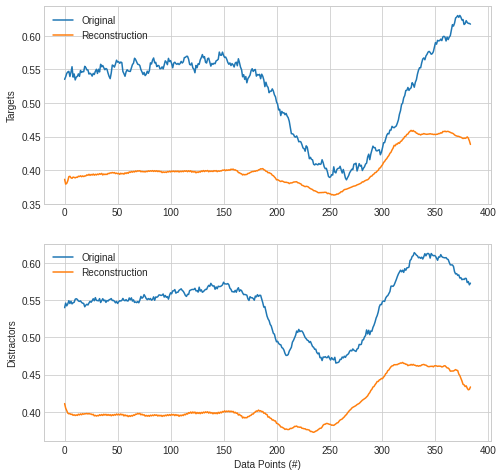

RMSE Targets: 0.12799136
RMSE Distractors: 0.139159


In [170]:
i = 16
fn = 'ee' + str(i)
plot_erp_reconstruction(erp[i], ee_rec[i], save=True, filename=fn)

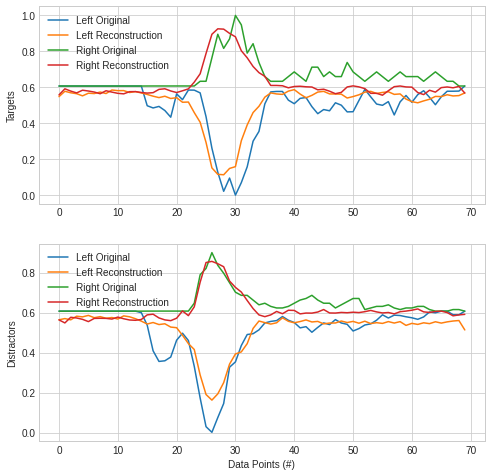

RMSE TL: 0.07818832
RMSE DL: 0.063026935
RMSE TR: 0.06916416
RMSE DR: 0.03810158


In [175]:
i = 16
fn = 'pp' + str(i)
plot_pupil_reconstruction(pupil[i], pp_rec[i], save=True, filename=fn)

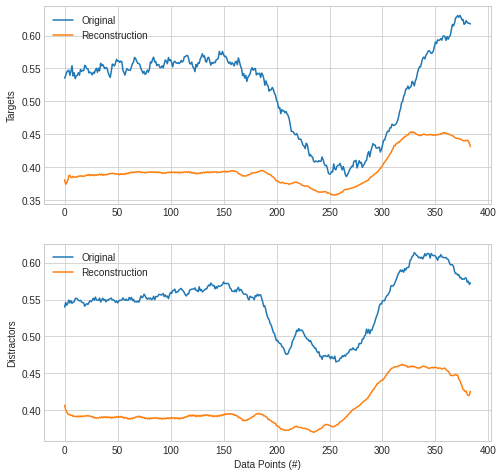

RMSE Targets: 0.13339669
RMSE Distractors: 0.14455555


In [181]:
i = 16
fn = 'pe' + str(i)
plot_erp_reconstruction(erp[i], pe_rec[i], save=True, filename=fn)

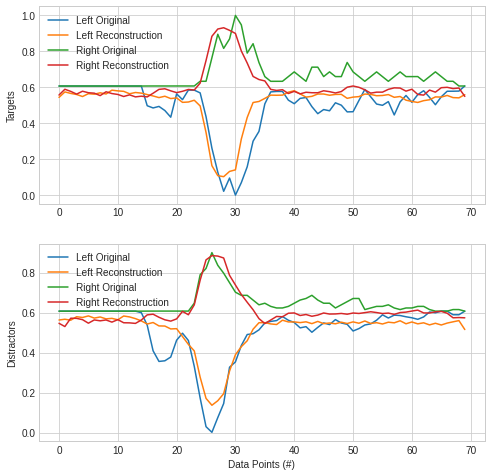

RMSE TL: 0.076659136
RMSE DL: 0.05806683
RMSE TR: 0.07603516
RMSE DR: 0.047411352


In [186]:
i = 16
fn = 'ep' + str(i)
plot_pupil_reconstruction(pupil[i], ep_rec[i], save=True, filename=fn)

In [ ]:
pupil_valid = [7 8 11 16]